This program uses the PlutoSDR to capture a second of samples and then compute the fft's over 5ms intervals
in order to generate a spectrogram. 
Some things to take into consideration:
    *Since the pluto returns IQ complex samples, it is sufficient for the sample rate to be equal to the bandwidth
    *A bandwidth/sample rate of 3MHz was chosen since the vqd seems to be limited to at least a 2MHz frequency rate
    *The buffer only returns 30,000 samples which is 5ms of samples, but the rx_samples array is zero-padded to 32768 
    which is a power of two so that the fft computation can be done faster
Future considerations:
    *I will create this into a class for testing purposes such as determining if polling one batch of samples and then
    computing the fft repeatedly is more efficient than using daemon threads
    *I will do the computations using Welch's method rather than a regular fft since it is supposedly faster, yet 
    rounds data which may or may not be beneficial

imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sys import argv
from pluto_lib import PlutoSDR
from scipy import signal

#allows plots to display in the notebook instead of another window
%matplotlib inline

configurations

In [30]:
RXLO = int(914e6) # center frequency to tune to
# RXLO = int(462e6)
RXBW = int(3e6) # bandwidth
RXFS = int(3e6) # sample rate

sdr = PlutoSDR()

sdr.rx_rf_port_select_chan0 = "A_BALANCED"
sdr.rx_lo = RXLO
sdr.sample_rate = RXFS
sdr.gain_control_mode_chan0 = "slow_attack"
sdr.rx_buffer_size = int(30e3)

fft_size = 32768
num_rows = 200

rx_samples = np.zeros((num_rows,fft_size), dtype=np.complex64)

#generate 5ms intervals for 1 second
t = np.arange(int(sdr.rx_buffer_size*num_rows))/RXFS

Collect samples

In [38]:
for k in range(200):
    rx_samples[k,:30000] = sdr.rx()

C:\Users\flaco\AppData\Local\Temp\ipykernel_30976\4076376041.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  rx_samples[k,:30000] = sdr.rx()


Process data using fft method
NOTE: Can only use fft or welch method once since the collected data is altered. New samples must be recollected if choosing running another method

C:\Users\flaco\AppData\Local\Temp\ipykernel_30976\752962585.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  rx_samples = rx_samples.astype('float64')


Text(0, 0.5, 'Time [5 ms]')

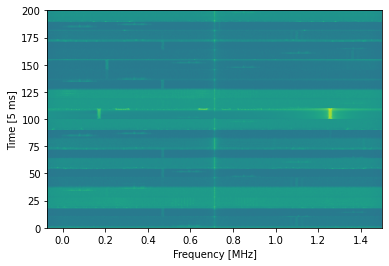

In [32]:
for i in range(num_rows):
    rx_samples[i,:] = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(rx_samples[i], 32768)))**2)

rx_samples = rx_samples.astype('float64')

#generates the spectogram
plt.imshow(rx_samples, aspect='auto', extent=[-RXFS/2/21e6, RXFS/2/1e6, 0, 200])
plt.xlabel("Frequency [MHz]")
plt.ylabel("Time [5 ms]")

# f = np.linspace(RXFS/-2, RXFS/2, len(rx_samples[0]))
# plt.figure()
# plt.plot()
# plt.show()

Process data using welch method

Text(0, 0.5, 'Time [5 ms]')

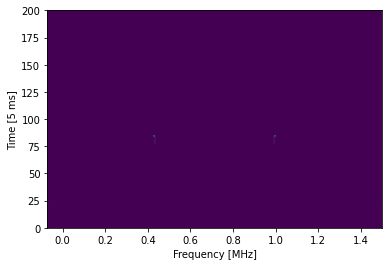

In [39]:
for i in range(num_rows):
    _, rx_samples[i,:4096] = signal.welch(rx_samples[i,:32000], RXFS, 'flattop', 4096, return_onesided=False, scaling='spectrum', average='median')
    # rx_samples[i,:256] = np.fft.fftshift(10*np.log10(np.abs(rx_samples[i,:256])/256)**2)
    rx_samples[i,:4096] = np.fft.fftshift(rx_samples[i,:4096])
    # rx_samples[i,:] = 10*np.log10(np.abs(np.fft.fftshift(signal.welch(rx_samples[i], RXFS, 'flattop', 128, return_onesided=False, scaling='spectrum', average='median')))**2)

#generates the spectogram
plt.imshow(rx_samples[:,:4096], aspect='auto', extent=[-RXFS/2/21e6, RXFS/2/1e6, 0, 200])
plt.xlabel("Frequency [MHz]")
plt.ylabel("Time [5 ms]")

Notes on results from above:
When it comes to frequency hopping, it appears welch's method may not be well suited for capturing the correct pattern. It is useful in discarding a lot of noise and uses a lot less memory, but a signal must be on for long durations for welch to fully capture it. For frequency hopping signals, it appears to not be good enough. 